In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cleaning import convert
from cleaning import splitter
from cleaning import text_preprocessing

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from typing import List
import torch

In [32]:
size = 500
filename = "imdb_df_500.csv"
root = f"C:/Users/Bijan-PC/Documents/Coding/UNIL/Data Analysis/ADA_Project/ADA_Final/dat_cleaned/{size}"      #base location for where all data files are
df = convert(root,filename)            #Definining dataframe where all training and validation data will be pulled from
df["id"] = df.index                            #creating id column
number_of_labels = len(df["label"].value_counts())          #number of labels (will be used when training)

In [33]:
number_of_labels

2

In [34]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_embeddings(texts: List[str], batch_size: int):
    all_embeddings = []
    print(f"Total number of records: {len(texts)}")
    print(f"Num batches: {(len(texts) // batch_size) + 1}")

    # Extract embeddings for the texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index + batch_size]

        # Generate tokens and move input tensors to GPU
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract the embeddings. no_grad because the gradient does not need to be computed
        # since this is not a learning task
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the last hidden stated and pool them into a mean vector calculated across the sequence length dimension
        # This will reduce the output vector from [batch_size, sequence_length, hidden_layer_size]
        # to [batch_size, hidden_layer_size] thereby generating the embeddings for all the sequences in the batch
        last_hidden_states = outputs.last_hidden_state
        embeddings = torch.mean(last_hidden_states, dim=1).cpu().tolist()

        # Append to the embeddings list
        all_embeddings.extend(embeddings)

    return all_embeddings

c:\Users\Bijan-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
# Split into train and test
X = df.text.values
y = df.label.values

X_test, y_test, X_train, y_train, X_val, y_val = splitter(X,y)

In [37]:
X_train = pd.DataFrame(X_train, columns=['text'])
X_val = pd.DataFrame(X_val, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_val = pd.Series(y_val)

In [38]:
for dataset in [X_test, X_train, X_val]:
    dataset["text_cleaned"] = dataset["text"].apply(lambda x: text_preprocessing(x))
    print(f'Cleaned {len(dataset["text_cleaned"])} records in dataset')

Cleaned 100 records in dataset
Cleaned 800 records in dataset
Cleaned 100 records in dataset


In [39]:
from collections import Counter

# Get class counts
print(Counter(y_train))

Counter({0: 408, 1: 392})


In [40]:

# Get embeddings for the training and test set
train_embeddings = get_embeddings(texts=X_train["text_cleaned"].tolist(), batch_size=256)
train_embeddings_df = pd.DataFrame(train_embeddings)

test_embeddings = get_embeddings(texts=X_test["text_cleaned"].tolist(), batch_size=256)
test_embeddings_df = pd.DataFrame(test_embeddings)

val_embeddings = get_embeddings(texts=X_val["text_cleaned"].tolist(), batch_size=256)
val_embeddings_df = pd.DataFrame(val_embeddings)

Total number of records: 800
Num batches: 4


100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Total number of records: 100
Num batches: 1


100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


Total number of records: 100
Num batches: 1


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


In [41]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    boost_device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not the cpu will be used
else:
    print('No GPU available, using the CPU instead.')
    boost_device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 SUPER


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def train_model(data: pd.DataFrame, labels: pd.Series):

    # Initialize the XGBoost Classifier
    clf = RandomForestClassifier(random_state=3137)

    # Define hyperparameters and values to tune
    param_grid = {
        'max_depth': [3, 5, 7, 9],
    }

    print(f"Number of rows in training data: {len(data)}")

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="roc_auc_ovo",
                               cv=5, verbose=3)
    grid_search.fit(data, labels)

    # Get the best hyperparameters
    best_max_depth = grid_search.best_params_['max_depth']

    final_clf = RandomForestClassifier(
                                      max_depth=best_max_depth,
                                      random_state=3137)
    final_clf.fit(data, labels)

    return final_clf

In [43]:

def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(number_of_labels, number_of_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    #plt.show()

Number of rows in training data: 800
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......................max_depth=3;, score=0.791 total time=   0.1s
[CV 2/5] END .......................max_depth=3;, score=0.707 total time=   0.1s
[CV 3/5] END .......................max_depth=3;, score=0.777 total time=   0.1s
[CV 4/5] END .......................max_depth=3;, score=0.761 total time=   0.1s
[CV 5/5] END .......................max_depth=3;, score=0.752 total time=   0.1s
[CV 1/5] END .......................max_depth=5;, score=0.784 total time=   0.2s
[CV 2/5] END .......................max_depth=5;, score=0.741 total time=   0.2s
[CV 3/5] END .......................max_depth=5;, score=0.763 total time=   0.2s
[CV 4/5] END .......................max_depth=5;, score=0.744 total time=   0.2s
[CV 5/5] END .......................max_depth=5;, score=0.753 total time=   0.2s
[CV 1/5] END .......................max_depth=7;, score=0.771 total time=   0.3s
[CV 2/5] END

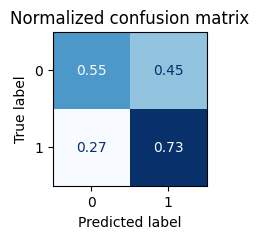

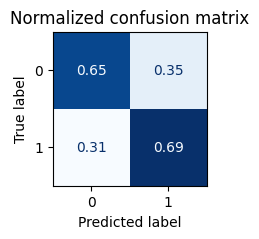

In [44]:
# Train model
rf_model = train_model(data=train_embeddings_df, labels=y_train)

# Predict from model on validation data
y_pred_val = rf_model.predict(val_embeddings_df)
#y_pred_labels = [label_dict[x] for x in y_pred]
y_pred_val = pd.Series(y_pred_val)


# Predict from model on test data
y_pred_test = rf_model.predict(test_embeddings_df)
#y_pred_labels = [label_dict[x] for x in y_pred]
y_pred_test = pd.Series(y_pred_test)

# Evaluate model (validation data)
print(f"Classification report:\n{classification_report(y_val, y_pred_val)}")
print(plot_confusion_matrix(y_val, y_pred_val))

# Evaluate model (test data)
print(f"Classification report:\n{classification_report(y_val, y_pred_test)}")
print(plot_confusion_matrix(y_test, y_pred_test))

In [49]:
y_pred_val.sample(100)

61    1
33    1
83    1
21    1
13    0
     ..
26    0
5     1
38    0
86    1
50    0
Length: 100, dtype: int64

In [ ]:
from BERT_RF import bert_rf

c:\Users\Bijan-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Cleaned 300 records in dataset
Cleaned 2400 records in dataset
Cleaned 300 records in dataset
Total number of records: 2400
Num batches: 10


100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.23it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 41.24it/s]


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 SUPER
Training...
Number of rows in training data: 2400
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......................max_depth=3;, score=0.761 total time=   0.5s
[CV 2/5] END .......................max_depth=3;, score=0.749 total time=   0.5s
[CV 3/5] END .......................max_depth=3;, score=0.773 total time=   0.5s
[CV 4/5] END .......................max_depth=3;, score=0.765 total time=   0.5s
[CV 5/5] END .......................max_depth=3;, score=0.772 total time=   0.5s
[CV 1/5] END .......................max_depth=5;, score=0.772 total time=   0.8s
[CV 2/5] END .......................max_depth=5;, score=0.778 total time=   0.8s
[CV 3/5] END .......................max_depth=5;, score=0.791 total time=   0.9s
[CV 4/5] END .......................max_depth=5;, score=0.784 total time=   0.8s
[CV 5/5] END .......................max_depth=5;, score=0.783 total time=   0.9s

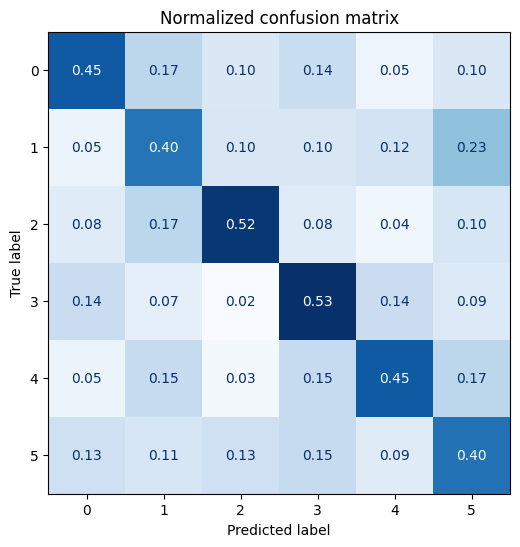

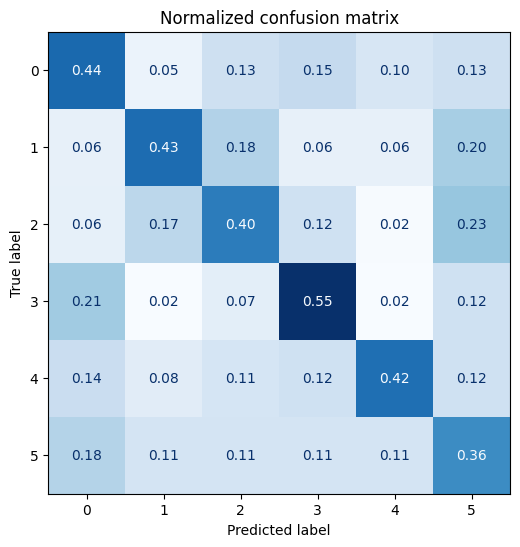

In [ ]:
bert_rf("twit_df_500.csv", 500, test=True)